**IDL ASSIGNMENT- CNN DENSENETs**                                       
Raj Rajeshwari Prasad                                   

**Step 1: Importing Libraries**

In [1]:
from tensorflow.keras.layers import BatchNormalization, ReLU,GlobalAveragePooling2D,GlobalAvgPool2D
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import time

**Step2: Loading Data**

In [2]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_labels = train_labels.reshape((-1))

train_data   = tf.data.Dataset.from_tensor_slices((train_images.reshape([-1,32,32,3]).astype(np.float32),train_labels.astype(np.int32)))
train_data= train_data.shuffle(buffer_size=60000).batch(500).repeat()

test_labels = test_labels.reshape((-1))
test_data = tf.data.Dataset.from_tensor_slices((test_images.reshape([-1,32,32,3]).astype(np.float32), test_labels.astype(np.int32))).batch(250)


170500096/170498071 [==============================] - 4s 0us/step


**Step3: Defining BatchNormalization, ReLU and Convo Layer Function**

The function takes tensor as an argument, number of filters and kernel size(filter size).

In [3]:
def bn_relu_conv(inp,filters,k_size):
  inp_map = BatchNormalization()(inp)
  inp_map = ReLU()(inp_map)
  inp_map = tf.keras.layers.Conv2D(filters,kernel_size=k_size,padding='same')(inp_map)#32x32x32
  return inp_map

**Step4: Defining Dense Block**

takes 'tensor' and reps in repetitions. exampe in first case it will take rep = 6.

conv1 layer is having kernel size = 3 and number of filters is 32
conv2 is identical to conv1
further conv2 and initial input(tensor) gets concatinated

example:                         
input image shape = 32x32x3                                  
tensor shape = 32x32x32(1st convo layer, input to block1)                                       
                                
                                                 
                                                                                    
when rep = 1                                          
conv1 shape = 32x32x32                                  
conv2 shape = 32x32x32                                   
tensor updated shape = 32x32x64
                                  
                                            
                                                                     
when rep = 2                  
conv1 = 32x32x32                              
conv2 = 32x32x32                              
tensor updated shape = 32x32x96

and so on........................                          
By doing this, we are able to make sure that output from previous layers in a block are passed on to every succesive layers.
                                       
                                       



In [4]:
def dense_block(tensor,rep):
  for i in range(rep):
    conv1 = bn_relu_conv(tensor,filters = 32,k_size = 3)#32x32x32
    tensor = tf.keras.layers.concatenate([conv1, tensor])#32x32x64

    conv2 = bn_relu_conv(conv1,  filters = 32,k_size = 3)#32x32x32
    tensor = tf.keras.layers.concatenate([conv2, conv1])#32x32x96

    conv3 = bn_relu_conv(conv2,  filters = 32,k_size = 3)#32x32x32
    tensor = tf.keras.layers.concatenate([conv3, conv2])#32x32x128
    #print(tensor)
  return (tensor)

**Step5: Defining Transition Block**                   
Each dense block produces( N x N x 32 ) filter maps. These maps are convoluted into a single layer and and down sampling is done using average pooling.

This has following benefits:-
* prevent overfitting
* prevent overshooting parameter counts

In [5]:
def transition_layer(concatinated_conv):
  #f = int(tf.keras.backend.int_shape(concatinated_conv)[-1] * theta)
  trans_conv = bn_relu_conv(concatinated_conv, filters=1, k_size=3)
  trans_conv = tf.keras.layers.MaxPooling2D(pool_size=2)(trans_conv)
  #print(trans_conv)
  return trans_conv

**Defining Hyperparameters and other parts of code**
The repetitions suggested here are from the paper'Densely connected convolutional networks' by 'Gao Huang'

In [6]:
repetitions = 4,8
inp = tf.keras.layers.Input((32,32,3))

The snipet below is the entry point to the main part of the program. This will generate a convolution layer that will be further fed to the 1st dense block.

In [7]:
tensor = bn_relu_conv(inp, filters= 32, k_size=3)

The snipet below uses both dense block and transition block and provides the dense net in the end

In [8]:
for reps in repetitions:
  concatinated_conv = dense_block(tensor,reps)
  tensor         = transition_layer(concatinated_conv)


In [9]:
#final_conv_layer= bn_relu_conv(concatinated_conv, filters=1, k_size=3)
#final_conv_layer = tf.keras.layers.MaxPooling2D(pool_size=2)(final_conv_layer)

This part is the mlp. The output from convo layer is fed to 10 output units with a softmax fucntion. This data from convo layer is 1st flattened and then used in output

In [10]:
flat = tf.keras.layers.Flatten()(tensor)
#output1 = tf.keras.layers.Dense(64, activation='relu')(flat)
output  = tf.keras.layers.Dense(10, activation= 'softmax')(flat)

initializing the model

In [11]:
model = tf.keras.Model(inp, output)

In [12]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 3)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         re_lu[0][0]                      
_______________________________________________________________________________________

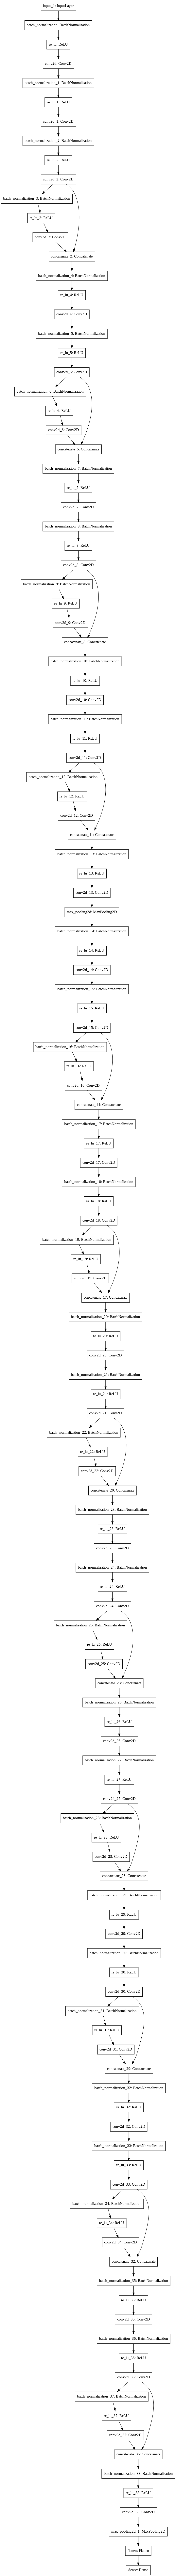

In [13]:
tf.keras.utils.plot_model(model, 'Model.png')

In [14]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history = model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=test_data)
#model.evaluate(test_data)


Epoch 1/100
100/100 [==============================] - 38s 384ms/step - loss: 2.2516 - accuracy: 0.1820 - val_loss: 2.3134 - val_accuracy: 0.1091
Epoch 2/100
100/100 [==============================] - 39s 387ms/step - loss: 2.1885 - accuracy: 0.2564 - val_loss: 2.3062 - val_accuracy: 0.1236
Epoch 3/100
100/100 [==============================] - 38s 381ms/step - loss: 2.1418 - accuracy: 0.3077 - val_loss: 2.2978 - val_accuracy: 0.1423
Epoch 4/100
100/100 [==============================] - 39s 386ms/step - loss: 2.1010 - accuracy: 0.3512 - val_loss: 2.2070 - val_accuracy: 0.2443
Epoch 5/100
100/100 [==============================] - 38s 383ms/step - loss: 2.0784 - accuracy: 0.3763 - val_loss: 2.1221 - val_accuracy: 0.3312
Epoch 6/100
100/100 [==============================] - 38s 384ms/step - loss: 2.0692 - accuracy: 0.3851 - val_loss: 2.1418 - val_accuracy: 0.3112
Epoch 7/100
100/100 [==============================] - 38s 384ms/step - loss: 2.0502 - accuracy: 0.4035 - val_loss: 2.0455 -

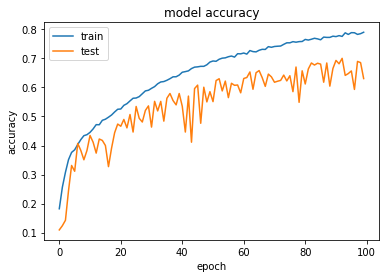

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

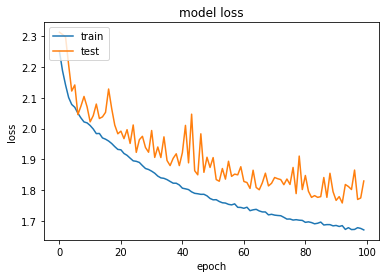

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()